In [1]:
import os
os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = "0.2"
import jax.numpy as jnp
from jax import grad, jit, vmap, random, nn, lax
import matplotlib.pyplot as plt
from backend import *
import numpy as np
import time

In [2]:
# inner loop
train_episodes = 500
tmax = 300

actor_eta = 0.01
critic_eta = 0.00
pc_eta = 0.0001
sigma_eta = 0.0001
constant_eta = 0.0001
normreward = False
etas = [pc_eta, sigma_eta,constant_eta, actor_eta,critic_eta]

numsigma = 2
gamma = 0.95
goalsize = 0.05
startcoord = [[-0.8,-0.8],[-0.8,0.8], [0,-0.8], [0,0.8]]
goalcoord = [0.8,0.8]
seed = 2021
obstacles = False

# outer loop
npc = 13**2
sigma = 0.1
alpha = 1.0
nact = 4
pctype = 'uni'

exptname = f'2D_PG_{npc}n_{seed}'

savevar = True

In [3]:
params = uniform_2D_pc_weights(npc, nact, seed, sigma=sigma,alpha=alpha, numsigma=numsigma)
initparams = params.copy()

2024-06-06 21:47:20.750183: W pjrt_plugin/src/mps_client.cc:534] WARNING: JAX Apple GPU support is experimental and not all JAX functionality is correctly supported!


Metal device set to: Apple M2 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



(169, 2)


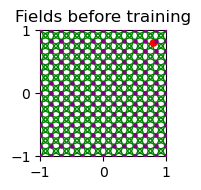

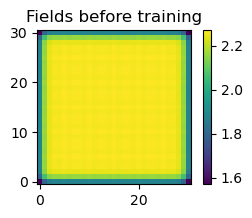

In [4]:
plot_place_cells(initparams, num=np.arange(npc), title='Fields before training',goalcoord=goalcoord, obstacles=obstacles, goalsize=goalsize)
plot_2D_density(initparams, title='Fields before training')

In [5]:
# inner loop training loop
def run_trial(params, env, trial):
    coords = []
    actions = []
    rewards = []

    state, goal, eucdist, done = env.reset()

    for i in range(tmax):

        pcact = predict_placecell(params, state[None,:])

        aprob = predict_action(params, pcact)

        onehotg = get_onehot_action(aprob)

        newstate, eucdist, done = env.step(onehotg) 

        reward = int(done)

        coords.append(state)
        actions.append(onehotg)
        rewards.append(reward)

        state = newstate.copy()

        if done:
            #print(f'Target reached at {i} step')
            break

    return jnp.array(coords), jnp.array(rewards), jnp.array(actions), i

In [6]:
latencys = []
allcoords = []
logparams = []
logparams.append(params)
env = TwoDimNav(startcoord=startcoord, goalcoord=goalcoord, goalsize=goalsize, tmax=tmax, obstacles=obstacles)

for episode in range(train_episodes):

    coords, rewards, actions, latency = run_trial(params, env, episode)
        
    discount_rewards = get_discounted_rewards(rewards, gamma=gamma)
    
    params, grads = update_params(params, coords, actions, discount_rewards, etas)

    allcoords.append(coords)
    logparams.append(params)
    latencys.append(latency)

    print(f'Trial {episode+1}, G {np.sum(discount_rewards)}, t {latency}')

Trial 1, G 0.0, t 299
Trial 2, G 0.0, t 299
Trial 3, G 0.0, t 299
Trial 4, G 0.0, t 299
Trial 5, G 0.0, t 299
Trial 6, G 0.0, t 299
Trial 7, G 0.0, t 299
Trial 8, G 0.0, t 299
Trial 9, G 0.0, t 299
Trial 10, G 0.0, t 299
Trial 11, G 0.0, t 299
Trial 12, G 0.0, t 299
Trial 13, G 0.0, t 299
Trial 14, G 0.0, t 299
Trial 15, G 19.99998664855957, t 289
Trial 16, G 0.0, t 299
Trial 17, G 0.0, t 299
Trial 18, G 19.791818618774414, t 88
Trial 19, G 0.0, t 299
Trial 20, G 19.942249298095703, t 113
Trial 21, G 0.0, t 299
Trial 22, G 0.0, t 299
Trial 23, G 0.0, t 299
Trial 24, G 0.0, t 299
Trial 25, G 0.0, t 299
Trial 26, G 0.0, t 299
Trial 27, G 0.0, t 299
Trial 28, G 0.0, t 299
Trial 29, G 0.0, t 299
Trial 30, G 19.999835968017578, t 228
Trial 31, G 0.0, t 299
Trial 32, G 0.0, t 299
Trial 33, G 19.356552124023438, t 66
Trial 34, G 0.0, t 299
Trial 35, G 0.0, t 299
Trial 36, G 19.999134063720703, t 195
Trial 37, G 0.0, t 299
Trial 38, G 19.999635696411133, t 212
Trial 39, G 0.0, t 299
Trial 40, 

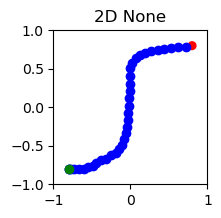

In [7]:
env.plot_trajectory()

47.5


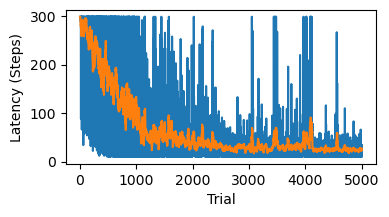

In [8]:
plt.figure(figsize=(4,2))
plt.plot(latencys)
plt.plot(moving_average(latencys, 20))
plt.xlabel('Trial')
plt.ylabel('Latency (Steps)')
perf = np.round(np.mean(latencys[-int(train_episodes*0.9):]),1)
print(perf)

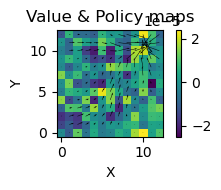

In [9]:
plot_maps(params[3],params[4],env, npc)

(169, 2)
(169, 2)


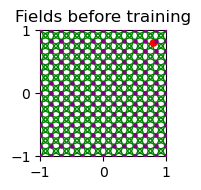

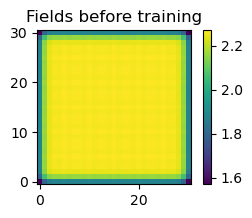

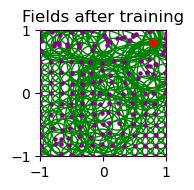

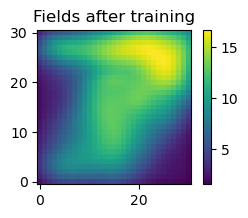

In [10]:
plot_place_cells(initparams, num=np.arange(npc), title='Fields before training',goalcoord=goalcoord, obstacles=obstacles, goalsize=goalsize)
plot_2D_density(initparams, title='Density before training')
plot_place_cells(params, num=np.arange(npc), title='Fields after training',goalcoord=goalcoord, obstacles=obstacles,goalsize=goalsize)
plot_2D_density(params, title='Density after training')

In [1]:
if savevar:
    saveload('./data/'+exptname, [logparams, allcoords, latencys], 'save')

NameError: name 'savevar' is not defined

In [7]:
[logparams, allcoords, latencys] = saveload('./data/'+exptname, 1, 'load')

gap = 20
end = 20
bins = 20

: 

-0.3664700533299358


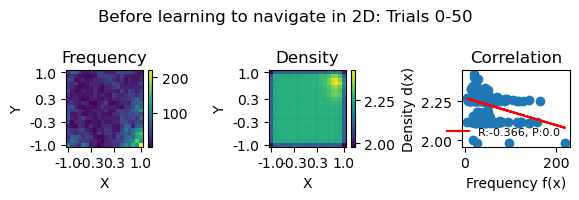

In [4]:
xs, visits, freq, density, corr = get_2D_freq_density_corr(allcoords, logparams, end=end, gap=gap, bins=bins)
plot_freq_density_corr(xs, freq, density,bins,title=f'Before learning to navigate in 2D: Trials {end-gap}-{end}')

0.1040224750019235


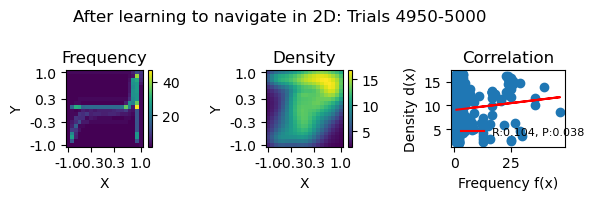

In [5]:
xs, visits, freq, density, corr = get_2D_freq_density_corr(allcoords, logparams, end=train_episodes, gap=gap, bins=bins)
plot_freq_density_corr(xs, freq, density,bins, title=f'After learning to navigate in 2D: Trials {train_episodes-gap}-{train_episodes}')

0
-0.23880157025664805
1
-0.29982114248965086
2
-0.3634090415795903
3
-0.04079867085945036
4
-0.24563911363883137
5
-0.32592759440921504
6
-0.3573124219783596
7
-0.2784072351591764
8
-0.3993325309694191
9
-0.362434424002939
10
-0.2858371072432815
11
-0.3777821532327341
12
-0.3309786305269561
13
-0.28924187547976216
14
-0.29023860608924756
15
-0.1984123320856166
16
-0.2920975192940931
17
-0.35006209767538116
18
-0.34189476246271167
19
-0.27850132246336723
20
-0.2664902374226673
21
-0.10007202166372568
22
-0.13662473080878562
23
-0.14800303778252977
24
-0.013357110407129153
25
0.0879474979880151
26
-0.19686195968480125
27
-0.21012834210518253
28
-0.09452932050184032
29
-0.13367884302618308
30
0.04504809191468638
31
0.2192296168596845
32
0.14561520856316476
33
0.14677921365629612
34
-0.04982029005373607
35
0.1356725347821695
36
0.002932488774837001
37
0.07660731410719983
38
0.04246654389930492
39
0.13396199810869042
40
0.09736321331848834
41
0.009269150849181198
42
-0.08751880093637458
43

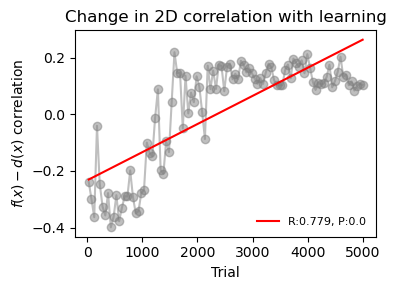

In [6]:
ends = np.linspace(26, train_episodes, train_episodes//gap, dtype=int)
correlations = []
for e, end in enumerate(ends):
    print(e)
    xs, visits, freq, density, corr = get_2D_freq_density_corr(allcoords, logparams, end=end, gap=gap, bins=bins)
    correlations.append(corr)

plt.figure(figsize=(4,3))
plt.title('Change in 2D correlation with learning')
plt.plot(ends, correlations, color='gray', marker='o',alpha=0.5)
slope, intercept, r_value, p_value, std_err = stats.linregress(np.array(ends).reshape(-1), np.array(correlations).reshape(-1))
regression_line = slope * np.array(ends).reshape(-1) + intercept
plt.plot(np.array(ends).reshape(-1), regression_line, color='red', label=f'R:{np.round(r_value,3)}, P:{np.round(p_value,3)}')
plt.legend(frameon=False, fontsize=8)
plt.xlabel('Trial')
plt.ylabel('$f(x)-d(x)$ correlation')
plt.tight_layout()